# Анализ лояльности пользователей Яндекс Афиши
Автор: Габдуллин Бақытжан Рафаэльұлы

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [92]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from phik import phik_matrix
import seaborn as sns

In [2]:
# Настраивание параметров подключения к базе данных
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-analyst-afisha'
}

In [3]:
# Формирование строки подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

In [4]:
# Создание объекта подключения к базе данных
engine = create_engine(connection_string)

In [5]:
# SQL-запрос для выгрузки данных
query = """
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    DATE_PART(
        'day',
        p.created_dt_msk -
        LAG(p.created_dt_msk) OVER (
            PARTITION BY p.user_id ORDER BY p.created_dt_msk
        )
    ) AS days_since_prev,
    p.event_id,
    p.service_name,
    e.event_type_main,
    c.city_name,
    r.region_name
FROM afisha.purchases p
JOIN afisha.events e ON p.event_id = e.event_id
JOIN afisha.city c ON e.city_id = c.city_id
JOIN afisha.regions r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main <> 'фильм';
"""


In [6]:
# Выгрузка данных в DataFrame
df = pd.read_sql_query(query, con=engine)
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Глиногорск,Каменевский регион
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Глиногорск,Каменевский регион
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Озёрск,Североярская область
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Родниковецк,Озернинский край


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [7]:
# Получение общей информации о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  city_name              290611 non-null  obje

In [8]:
# Просмотр статистики по числовым полям
df.describe()

,order_id,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,625.584360,2.754311,3.222381,438019.834992
std,2.497551e+06,1227.693064,1.170620,11.350509,147423.078841
min,1.000000e+00,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,81174.540000,57.000000,148.000000,592325.000000


In [9]:
# Проверка пропусков
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
service_name                 0
event_type_main              0
city_name                    0
region_name                  0
dtype: int64

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [10]:
# Загрузка таблицы с курсом тенге
tenge_rate = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
tenge_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [11]:
# Переименование название столбцов
df = df.rename(columns={
    'created_dt_msk': 'order_dt',
    'created_ts_msk': 'order_ts'
})

In [12]:
# Приведение даты к datetime
df['order_dt'] = pd.to_datetime(df['order_dt'])
df['order_ts'] = pd.to_datetime(df['order_ts'])
tenge_rate['data'] = pd.to_datetime(tenge_rate['data'])

df['order_date_only'] = df['order_dt'].dt.normalize()

In [13]:
# Выполнение объединения (merge) по дате
df = df.merge(
    tenge_rate[['data', 'curs']],
    left_on='order_date_only',
    right_on='data',
    how='left'
)

In [14]:
# Создание нового столбца revenue_rub, копируем revenue по умолчанию
df['revenue_rub'] = df['revenue']

# Конвертация значений в тенге в рубли
mask_kzt = df['currency_code'] == 'kzt'

df.loc[mask_kzt, 'revenue_rub'] = (
    df.loc[mask_kzt, 'revenue'] * (df.loc[mask_kzt, 'curs'] / 100)
)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  city_name              290611 non-null  obje

**Приведение выручки к единой валюте**

В данных присутствуют заказы, оплаченные в рублях (`rub`) и тенге (`kzt`).  
Чтобы анализировать метрику корректно, выручка была приведена к рублям.

Для пересчёта использован датасет `final_tickets_tenge_df.csv`, содержащий курс рубля к тенге (значение указано за 100 KZT). После приведения дат к одному формату таблицы были объединены по дате заказа.

Создан новый столбец `revenue_rub`:
- для `rub` значение сохранено без изменений;
- для `kzt` применена формула: **revenue_rub = revenue * (curs / 100)**.

После преобразований структура таблицы включает дополнительные столбцы `curs` и `revenue_rub`, все типы данных корректны.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [16]:
# Преобразование типы данных
df['tickets_count'] = df['tickets_count'].astype('int64')
df['revenue_rub'] = df['revenue_rub'].astype('float')

In [17]:
# Проверика ключевых категориальных столбцов
for col in ['device_type_canonical', 'currency_code', 'event_type_main',
            'service_name', 'city_name', 'region_name']:
    print(col, df[col].unique()[:10])

device_type_canonical ['mobile' 'desktop']
currency_code ['rub' 'kzt']
event_type_main ['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
service_name ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры']
city_name ['Глиногорск' 'Озёрск' 'Родниковецк' 'Кристалевск' 'Дальнозолотск'
 'Радужнополье' 'Радужсвет' 'Кумсай' 'Верховино' 'Светополье']
region_name ['Каменевский регион' 'Североярская область' 'Озернинский край'
 'Лугоградская область' 'Поленовский край' 'Широковская область'
 'Медовская область' 'Златопольский округ' 'Малиновоярский округ'
 'Яблоневская область']


In [18]:
# Основная статистика revenue_rub и tickets_count
df[['revenue_rub', 'tickets_count']].describe()

,revenue_rub,tickets_count
count,290611.000000,290611.000000
mean,555.571987,2.754311
std,875.498172,1.170620
min,-90.760000,1.000000
25%,113.970000,2.000000
50%,351.140000,3.000000
75%,802.050000,4.000000
max,81174.540000,57.000000


<AxesSubplot:>

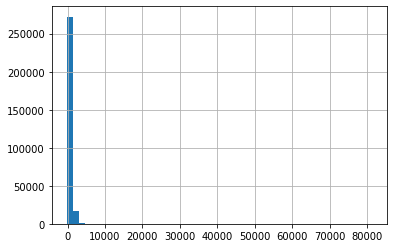

In [19]:
#Гистограммы
df['revenue_rub'].hist(bins=50)

In [20]:
# Фильтр по 99 перцентилю
df_original = df.copy()
p99 = df['revenue_rub'].quantile(0.99)
df = df[df['revenue_rub'] <= p99]

In [21]:
# Проверка, сколько строк ушло после фильтрации
rows_before = len(df_original)
rows_after = len(df)
rows_before - rows_after

2825

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [22]:
# Сортировка по пользователю и времени заказа
df = df.sort_values(by=['user_id', 'order_ts'])

In [23]:
# Агрегация данных по пользователям
user_profile = df.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'), #дата первого заказа
    last_order_dt=('order_dt', 'max'), #дата последнего заказа
    first_device=('device_type_canonical', 'first'), #устройство, с которого был сделан первый заказ
    first_region=('region_name', 'first'), #регион, в котором был сделан первый заказ
    first_service=('service_name', 'first'), #билетный партнёр, к которому обращались при первом заказе
    first_event_type=('event_type_main', 'first'), #жанр первого посещённого мероприятия
    orders_count=('order_id', 'count'), #общее количество заказов
    avg_revenue_rub=('revenue_rub', 'mean'), #средняя выручка с одного заказа в рублях
    avg_tickets_count=('tickets_count', 'mean'), #среднее количество билетов в заказе
    avg_days_between=('days_since_prev', 'mean') #среднее время между заказами
).reset_index()

In [24]:
# Добавляем две бинарные признаки
user_profile['is_two'] = (user_profile['orders_count'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['orders_count'] >= 5).astype(int)

In [25]:
user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,orders_count,avg_revenue_rub,avg_tickets_count,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [26]:
#Общее число пользователей
total_users = user_profile['user_id'].nunique()
total_users

21854

In [27]:
#Средняя выручка с одного заказа
avg_order_revenue = user_profile['avg_revenue_rub'].mean()
avg_order_revenue

544.398050897431

In [28]:
#Доля пользователей с 2+ заказами
share_two = user_profile['is_two'].mean()
share_two

0.6170952686007138

In [29]:
#Доля пользователей с 5+ заказами
share_five = user_profile['is_five'].mean()
share_five

0.2900613160062231

In [30]:
#Число заказов на пользователя
user_profile['orders_count'].describe()

count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10181.000000
Name: orders_count, dtype: float64

In [32]:
#Среднее число билетов в заказе
user_profile['avg_tickets_count'].describe()

count    21854.000000
mean         2.743129
std          0.913080
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max         11.000000
Name: avg_tickets_count, dtype: float64

In [33]:
#Среднее время между покупками
user_profile['avg_days_between'].describe()

count    13513.000000
mean        15.851275
std         22.306224
min          0.000000
25%          1.000000
50%          8.000000
75%         20.428571
max        148.000000
Name: avg_days_between, dtype: float64

In [35]:
#Проверка аномалий
user_profile['orders_count'].quantile([0.95, 0.99])


0.95     31.35
0.99    152.00
Name: orders_count, dtype: float64

In [36]:
#Проверка аномалий
user_profile['avg_tickets_count'].quantile([0.95, 0.99])

0.95    4.0
0.99    5.0
Name: avg_tickets_count, dtype: float64

**Анализ пользовательских профилей**

На основе агрегированных профилей пользователей был проведён анализ данных для выявления возможных аномалий.

В выборке представлено **21 854 уникальных пользователя**. Средняя выручка с одного заказа составляет около **544 рублей**.

Анализ повторных покупок показал, что:
- **около 62% пользователей** совершили **2 и более заказа**;
- **около 29% пользователей** совершили **5 и более заказов**.

Это говорит о наличии значимой доли лояльной аудитории.

Распределение количества заказов на пользователя имеет выраженную правостороннюю асимметрию. Медианное значение равно **2 заказам**, при этом:
- **95% пользователей** совершают не более **31 заказа**;
- **99% пользователей** — не более **152 заказов**.

Максимальные значения существенно превышают типичное поведение и, вероятно, относятся к аномальным или техническим пользователям, однако их доля в выборке крайне мала.

Среднее количество билетов в заказе распределено значительно стабильнее. Медианное значение составляет около **2.75 билета**, а:
- **95-й перцентиль** равен **4 билетам**;
- **99-й перцентиль** — **5 билетам**.

Это указывает на отсутствие критических выбросов по данному показателю.

Среднее время между покупками рассчитано для пользователей с более чем одним заказом. Медианное значение составляет **8 дней**, а 75% пользователей совершают повторную покупку в течение **примерно 20 дней**. Максимальное значение (**148 дней**) отражает наличие пользователей с редкими, но повторными покупками.

В целом данные обладают достаточным объёмом и качеством для дальнейшего анализа. Аномальные значения по числу заказов встречаются редко и не оказывают существенного влияния на общую картину, поэтому было принято решение **не применять дополнительную фильтрацию пользовательских профилей**.


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [37]:
# Функция для подсчёта пользователей и их доли по сегментам
def segment_distribution(df, column):
    result = (
        df.groupby(column)['user_id']
        .nunique()
        .reset_index(name='users_count')
    )
    result['share'] = result['users_count'] / result['users_count'].sum()
    return result.sort_values('users_count', ascending=False)

In [38]:
#Распределение по типу первого мероприятия
event_type_dist = segment_distribution(user_profile, 'first_event_type')
event_type_dist

,first_event_type,users_count,share
2,концерты,9643,0.441246
1,другое,5490,0.251213
5,театр,4289,0.196257
4,стендап,1118,0.051158
3,спорт,801,0.036652
0,выставки,418,0.019127
6,ёлки,95,0.004347


In [39]:
#Распределение по устройству первого заказа
device_dist = segment_distribution(user_profile, 'first_device')
device_dist

,first_device,users_count,share
1,mobile,18108,0.82859
0,desktop,3746,0.17141


In [40]:
#Распределение по региону первого заказа
region_dist = segment_distribution(user_profile, 'first_region')
region_dist.head(10)

,first_region,users_count,share
23,Каменевский регион,7159,0.327583
60,Североярская область,3799,0.173835
77,Широковская область,1237,0.056603
45,Озернинский край,678,0.031024
41,Малиновоярский округ,529,0.024206
76,Шанырский регион,503,0.023016
74,Травяная область,493,0.022559
57,Светополянский округ,464,0.021232
52,Речиновская область,446,0.020408
78,Яблоневская область,416,0.019035


In [41]:
#Распределение по билетному оператору
service_dist = segment_distribution(user_profile, 'first_service')
service_dist

,first_service,users_count,share
3,Билеты без проблем,5223,0.238995
22,Мой билет,2992,0.136909
19,Лови билет!,2848,0.130319
4,Билеты в руки,2594,0.118697
23,Облачко,2194,0.100394
7,Весь в билетах,1304,0.059669
20,Лучшие билеты,1188,0.054361
24,Прачечная,588,0.026906
17,Край билетов,459,0.021003
12,Дом культуры,358,0.016381


**Распределение пользователей по признакам первого заказа**

На этом этапе проанализировано распределение пользователей по характеристикам их **первого заказа**: тип мероприятия, устройство, регион и билетный оператор. Это позволяет выявить основные точки входа пользователей на платформу.

**Тип первого мероприятия**
- Самый распространённый тип первого события — **концерты** (около 44% пользователей).
- Далее следуют категории **«другое»** (≈25%) и **театр** (≈20%).
- Остальные типы мероприятий (стендап, спорт, выставки, ёлки) имеют заметно меньшие доли.
  
Распределение неравномерное — концерты являются основной точкой входа.

**Устройство первого заказа**
- Большинство пользователей совершили первый заказ с **мобильных устройств** (≈83%).
- Заказы с **десктопа** составляют около 17%.

Мобильные устройства — ключевой канал привлечения пользователей.

**Регион первого заказа**
- Лидирует **Каменевский регион** (≈33% пользователей).
- На втором месте **Североярская область** (≈17%).
- Далее наблюдается резкое снижение долей и «длинный хвост» регионов.

Пользователи сконцентрированы в нескольких крупных регионах.

**Билетный оператор первого заказа**
- Наиболее популярные операторы:
  - *Билеты без проблем* (≈24%)
  - *Мой билет* (≈14%)
  - *Лови билет!* (≈13%)
- Остальные операторы представлены значительно меньшими сегментами.

Наблюдается явная концентрация пользователей у ограниченного числа билетных операторов.

**Вывод**
Пользователи распределены по сегментам неравномерно. Основные точки входа на платформу:
- концерты как первый тип мероприятия;
- мобильные устройства как основной канал;
- несколько ключевых регионов и билетных операторов.

Эти сегменты представляют наибольший интерес для дальнейшего анализа возврата пользователей.


---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [42]:
# Функция: считаем размер сегмента и долю возвратов
def segment_returns(df, segment_col, target_col='is_two'):
    seg = (
        df.groupby(segment_col)
          .agg(users_count=('user_id', 'nunique'),
               return_rate=(target_col, 'mean'))
          .reset_index()
          .sort_values('users_count', ascending=False)
    )
    return seg

In [46]:
# Функция: строим график (топ-N по размеру сегмента)
def plot_segment_returns(seg_df, segment_col, top_n=10, title=''):
    plot_df = seg_df.head(top_n).sort_values('return_rate', ascending=True)

    plt.figure(figsize=(10, 5))
    plt.barh(plot_df[segment_col].astype(str), plot_df['return_rate'])
    plt.axvline(share_two, linestyle='--')  # среднее по выборке
    plt.xlabel('Доля пользователей с 2+ заказами (is_two)')
    plt.ylabel('Сегмент')
    plt.title(title)
    plt.tight_layout()
    plt.show()

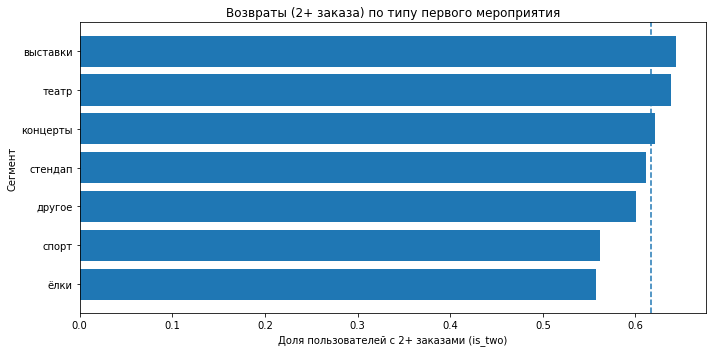

In [47]:
# По типу первого мероприятия
event_returns = segment_returns(user_profile, 'first_event_type')
plot_segment_returns(
    event_returns,
    'first_event_type',
    top_n=len(event_returns),
    title='Возвраты (2+ заказа) по типу первого мероприятия'
)

In [55]:
event_returns.sort_values(by='return_rate', ascending=False)

,first_event_type,users_count,return_rate
0,выставки,418,0.643541
5,театр,4289,0.638144
2,концерты,9643,0.621591
4,стендап,1118,0.611807
1,другое,5490,0.600911
3,спорт,801,0.561798
6,ёлки,95,0.557895


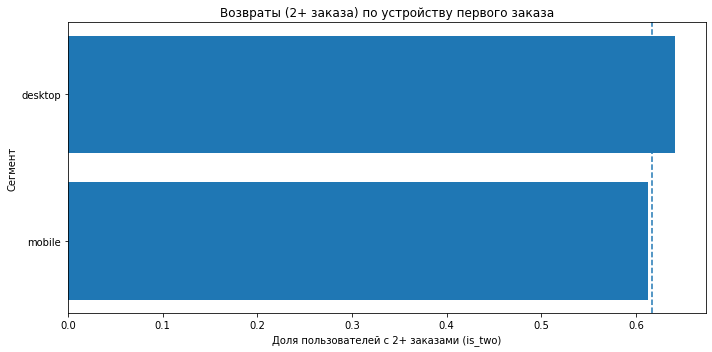

In [48]:
# По устройству первого заказа
device_returns = segment_returns(user_profile, 'first_device')
plot_segment_returns(
    device_returns,
    'first_device',
    top_n=len(device_returns),
    title='Возвраты (2+ заказа) по устройству первого заказа'
)

In [56]:
device_returns.sort_values(by='return_rate', ascending=False)

,first_device,users_count,return_rate
0,desktop,3746,0.641217
1,mobile,18108,0.612105


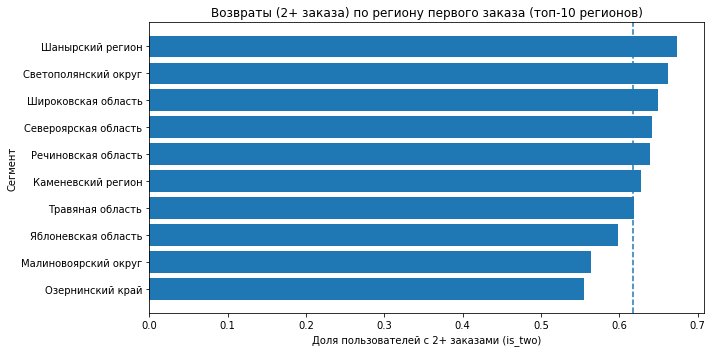

In [49]:
# По региону первого заказа (топ-10 по числу пользователей)
region_returns = segment_returns(user_profile, 'first_region')
plot_segment_returns(
    region_returns,
    'first_region',
    top_n=10,
    title='Возвраты (2+ заказа) по региону первого заказа (топ-10 регионов)'
)

In [57]:
region_returns.head(10).sort_values(by='return_rate', ascending=False)

,first_region,users_count,return_rate
76,Шанырский регион,503,0.673956
57,Светополянский округ,464,0.661638
77,Широковская область,1237,0.649151
60,Североярская область,3799,0.641221
52,Речиновская область,446,0.639013
23,Каменевский регион,7159,0.627881
74,Травяная область,493,0.618661
78,Яблоневская область,416,0.598558
41,Малиновоярский округ,529,0.563327
45,Озернинский край,678,0.554572


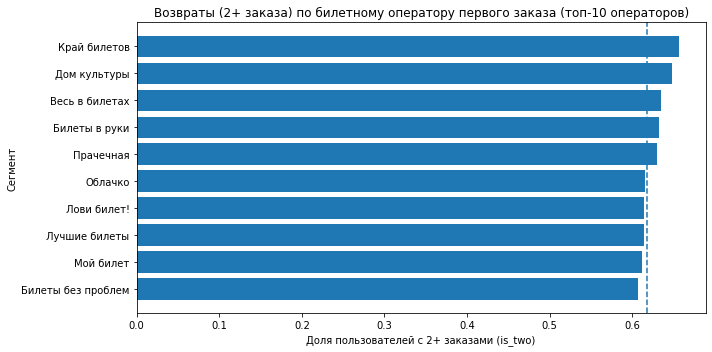

In [50]:
# По билетному оператору первого заказа (топ-10 по числу пользователей)
service_returns = segment_returns(user_profile, 'first_service')
plot_segment_returns(
    service_returns,
    'first_service',
    top_n=10,
    title='Возвраты (2+ заказа) по билетному оператору первого заказа (топ-10 операторов)'
)

In [58]:
service_returns.head(10).sort_values(by='return_rate', ascending=False)

,first_service,users_count,return_rate
17,Край билетов,459,0.655773
12,Дом культуры,358,0.648045
7,Весь в билетах,1304,0.634202
4,Билеты в руки,2594,0.632228
24,Прачечная,588,0.629252
23,Облачко,2194,0.615770
19,Лови билет!,2848,0.614466
20,Лучшие билеты,1188,0.613636
22,Мой билет,2992,0.611631
3,Билеты без проблем,5223,0.606931


**Анализ возвратов пользователей**

Для оценки возвратов пользователей была рассчитана доля клиентов, совершивших **два и более заказа** (`return_rate`), в разрезе признаков первого заказа: типа мероприятия, устройства, региона и билетного оператора. В качестве ориентира используется средняя доля возвратов по всей выборке — **≈ 61,7%**.

**Тип первого мероприятия**
Наиболее высокую долю возвратов показывают пользователи, чей первый заказ был связан с:
- **выставками** (~64,4%);
- **театром** (~63,8%);
- **концертами** (~62,2%).

Сегменты «спорт» и «ёлки» демонстрируют более низкие показатели возврата, однако их вклад ограничен небольшим размером аудитории.

**Тип устройства первого заказа**
Пользователи, начавшие взаимодействие с платформой через **desktop**, возвращаются чаще (64,1%), чем пользователи **mobile** (61,2%). При этом мобильный сегмент значительно больше по объёму, поэтому именно он формирует основную массу повторных заказов.

**Регион первого заказа**
Среди крупных регионов повышенные показатели возврата наблюдаются, например, у пользователей из:
- **Широковской области** (~64,9%);
- **Североярской области** (~64,1%);
- **Шанырского региона** (~67,4%).

При этом различия между регионами умеренные, а высокая вариативность частично объясняется размером сегментов.

**Билетный оператор первого заказа**
Выше среднего уровня возвратов находятся пользователи, начавшие с операторов:
- **Край билетов** (~65,6%);
- **Дом культуры** (~64,8%);
- **Весь в билетах** (~63,4%).

Крупнейшие операторы («Билеты без проблем», «Мой билет», «Лови билет!») показывают значения близкие к среднему по выборке.

---

**Выводы**
- Пользователи чаще возвращаются на платформу после первого заказа на **выставки, театральные мероприятия и концерты**.
- **Desktop**-пользователи демонстрируют более высокую лояльность, однако основной вклад в повторные заказы даёт мобильный сегмент из-за его масштаба.
- Наблюдаются **успешные «точки входа»** — отдельные типы мероприятий, регионы и билетные операторы, где доля повторных заказов стабильно выше среднего.
- При интерпретации результатов важно учитывать размер сегментов: небольшие группы могут показывать завышенные или нестабильные значения.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [60]:
event_returns.loc[
    event_returns['first_event_type'].isin(['спорт', 'концерты']),
    ['first_event_type', 'users_count', 'return_rate']
]

,first_event_type,users_count,return_rate
2,концерты,9643,0.621591
3,спорт,801,0.561798


In [62]:
region_returns[['users_count', 'return_rate']].corr()

,users_count,return_rate
users_count,1.000000,0.119474
return_rate,0.119474,1.000000


**Проверка продуктовых гипотез**

**Гипотеза 1. Тип мероприятия влияет на вероятность возврата на платформу: пользователи, которые совершили первый заказ на спортивные мероприятия, возвращаются чаще, чем пользователи, начавшие с концертов.**

Для проверки гипотезы сравнили долю пользователей, совершивших повторный заказ, для двух сегментов:
- первый заказ — концерты;
- первый заказ — спортивные мероприятия.

Результаты:
- **Концерты:** доля возвратов ≈ **62%** (9643 пользователя);
- **Спорт:** доля возвратов ≈ **56%** (801 пользователь).

👉 Пользователи, начавшие с концертов, возвращаются **чаще**, чем пользователи, начавшие со спортивных мероприятий.

**Вывод:** гипотеза **не подтверждается**. Тип мероприятия действительно влияет на возврат, однако направление влияния противоположно ожидаемому: концерты являются более сильной точкой входа, чем спорт.

---

**Гипотеза 2. В регионах с наибольшим числом пользователей доля повторных заказов выше, чем в менее активных регионах.**

Для проверки гипотезы изучили связь между:
- количеством пользователей в регионе;
- долей пользователей, совершивших повторный заказ.

Была рассчитана корреляция между `users_count` и `return_rate`.

Результат:
- коэффициент корреляции приблизительно **0.12**.

👉 Связь между размером региона и долей возвратов **слабая и практически отсутствует**.

Также среди регионов с большим числом пользователей доля возвратов варьируется в широком диапазоне и не демонстрирует устойчивого роста.

**Вывод:** гипотеза **не подтверждается**. Высокая активность региона по числу пользователей не гарантирует более высокую долю повторных заказов.

---

**Общий вывод**
- Возврат пользователей зависит от характеристик первого заказа, однако не все популярные сегменты являются эффективными «точками входа».
- Концерты выступают более успешным стартовым типом мероприятия с точки зрения удержания.
- Размер региона не является надёжным фактором, объясняющим повторные заказы, и требует более детального анализа с учётом дополнительных признаков.


---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [63]:
# Пользователи с одним заказом
one_order_users = user_profile[user_profile['orders_count'] == 1]

# Пользователи с двумя и более заказами
repeat_users = user_profile[user_profile['orders_count'] >= 2]

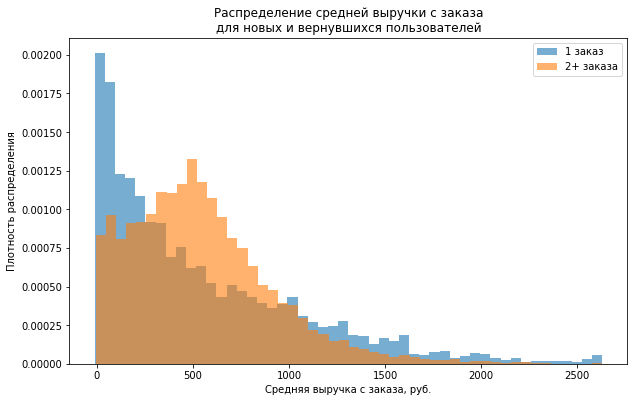

In [64]:
#Сравнительные гистограммы средней выручки
plt.figure(figsize=(10, 6))

plt.hist(
    one_order_users['avg_revenue_rub'],
    bins=50,
    alpha=0.6,
    density=True,
    label='1 заказ'
)

plt.hist(
    repeat_users['avg_revenue_rub'],
    bins=50,
    alpha=0.6,
    density=True,
    label='2+ заказа'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа\nдля новых и вернувшихся пользователей')
plt.legend()

plt.show()


In [65]:
one_order_users['avg_revenue_rub'].describe()

count    8368.000000
mean      545.295642
std       519.514097
min       -10.770000
25%       132.070000
50%       378.030000
75%       830.317500
max      2628.421739
Name: avg_revenue_rub, dtype: float64

In [66]:
repeat_users['avg_revenue_rub'].describe()

count    13486.000000
mean       543.841100
std        366.645729
min         -5.385000
25%        274.112500
50%        497.621965
75%        739.353324
max       2628.421739
Name: avg_revenue_rub, dtype: float64

**Связь средней выручки с заказа и повторных покупок**

Для анализа пользователи были разделены на две группы:
- пользователи, совершившие **один заказ**;
- пользователи, совершившие **два и более заказов**.

Сравнение распределений средней выручки с заказа показало следующие результаты:

- **Средняя выручка** в обеих группах практически одинакова:
  - 1 заказ — около **545 руб.**
  - 2+ заказов — около **544 руб.**

- **Медианная выручка** у вернувшихся пользователей заметно выше:
  - 1 заказ — **378 руб.**
  - 2+ заказов — **498 руб.**

- Основная масса пользователей с **одним заказом** сконцентрирована в диапазоне **100–400 руб.**,  
  тогда как у вернувшихся пользователей распределение смещено вправо — в диапазон **300–800 руб.**

- У пользователей с одним заказом наблюдается **больший разброс значений**, включая более низкие и экстремальные значения выручки.

**Вывод:**  
Пользователи, совершающие повторные заказы, в среднем оформляют **более дорогие заказы**, особенно это видно по медиане и основн


---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [67]:
# Пользователи, совершившие 2–4 заказа
group_2_4 = user_profile.loc[user_profile['orders_count'].between(2, 4), 'avg_revenue_rub']
# Пользователи, совершившие 5 и более заказов
group_5_plus = user_profile.loc[user_profile['orders_count'] >= 5, 'avg_revenue_rub']

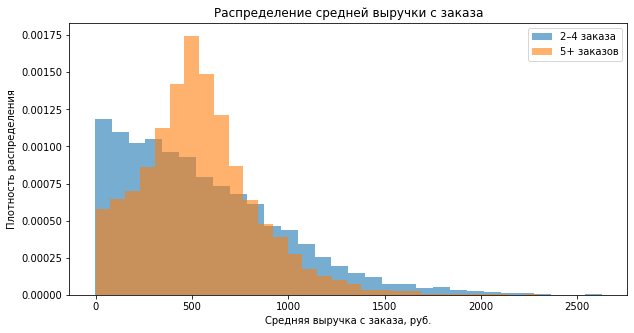

In [72]:
# Строим гистограммы
plt.figure(figsize=(10, 5))

plt.hist(
    group_2_4,
    bins=30,
    alpha=0.6,
    density=True,
    label='2–4 заказа'
)

plt.hist(
    group_5_plus,
    bins=30,
    alpha=0.6,
    density=True,
    label='5+ заказов'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа')
plt.legend()

plt.show()

In [70]:
group_2_4.describe()

count    7147.000000
mean      551.572386
std       420.197691
min        -5.385000
25%       218.428750
50%       471.266667
75%       798.550000
max      2628.421739
Name: avg_revenue_rub, dtype: float64

In [71]:
group_5_plus.describe()

count    6339.000000
mean      535.124347
std       294.615103
min         0.000000
25%       336.966333
50%       513.560000
75%       690.016087
max      2299.869022
Name: avg_revenue_rub, dtype: float64

**Вывод**

Было проведено сравнение распределения средней выручки с заказа (`avg_revenue_rub`) для двух групп пользователей:
– пользователи, совершившие 2–4 заказа;
– пользователи, совершившие 5 и более заказов.

Средняя выручка с заказа в обеих группах находится на сопоставимом уровне:

– для пользователей с 2–4 заказами среднее значение составляет около 552 рублей;

– для пользователей с 5 и более заказами — около 535 рублей.

При этом медианная выручка выше у пользователей с 5 и более заказами (примерно 514 рублей против 471 рубля у пользователей с 2–4 заказами), что указывает на более стабильный уровень заказов в этой группе.

Распределение выручки у пользователей с 2–4 заказами наблюдается больший разброс значений и чаще встречаются более дорогие разовые заказы. У пользователей с 5 и более заказами распределение сконцентрировано в среднем ценовом диапазоне.

Таким образом, существенных различий по уровню средней выручки с заказа между пользователями с 2–4 заказами и пользователями с 5 и более заказами не выявлено. Основное различие между группами заключается не в размере заказов, а в стабильности и регулярности покупок.


---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [73]:
# Распределение среднего количества билетов
user_profile['avg_tickets_count'].describe()

count    21854.000000
mean         2.743129
std          0.913080
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max         11.000000
Name: avg_tickets_count, dtype: float64

In [74]:
# Сегментация по среднему числу билетов
user_profile['tickets_segment'] = pd.cut(
    user_profile['avg_tickets_count'],
    bins=[1, 2, 3, 5, float('inf')],
    right=True,
    include_lowest=True,
    labels=[
        '1–2 билета',
        '2–3 билета',
        '3–5 билетов',
        '5+ билетов'
    ]
)

In [76]:
#Подсчёт пользователей и доли возвратов по сегментам
tickets_returns = (
    user_profile
    .groupby('tickets_segment')
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
)

tickets_returns

,tickets_segment,users_count,return_rate
0,1–2 билета,6160,0.401461
1,2–3 билета,10144,0.748127
2,3–5 билетов,5356,0.627521
3,5+ билетов,194,0.324742


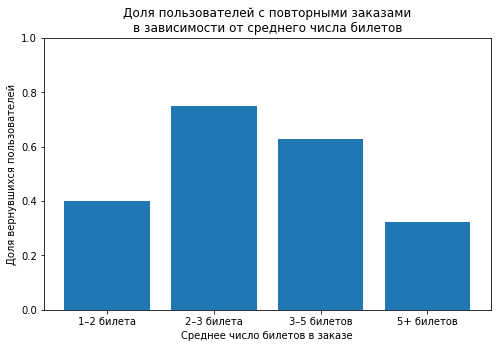

In [78]:
#График доли возвратов
plt.figure(figsize=(8, 5))
plt.bar(
    tickets_returns['tickets_segment'],
    tickets_returns['return_rate']
)
plt.title('Доля пользователей с повторными заказами\nв зависимости от среднего числа билетов')
plt.ylabel('Доля вернувшихся пользователей')
plt.xlabel('Среднее число билетов в заказе')
plt.ylim(0, 1)
plt.show()

**Влияние среднего количества билетов в заказе**

Большинство пользователей покупают в среднем от **2 до 3 билетов**: медианное значение `avg_tickets_count` составляет **2.75**, а 75% пользователей покупают не более **3.1 билета**. Значения выше 5 билетов встречаются редко и относятся к небольшому числу пользователей.

При сегментации по среднему количеству билетов в заказе получены следующие результаты:

- **1–2 билета** — около 6 тыс. пользователей, доля повторных заказов ~**40%**  
- **2–3 билета** — самый массовый сегмент (более 10 тыс. пользователей) и **наивысшая доля возврата (~75%)**
- **3–5 билетов** — средний по размеру сегмент, доля возврата ~**63%**
- **5+ билетов** — очень малочисленный сегмент, доля повторных заказов ниже **35%**

Пользователи распределены **неравномерно**: основная концентрация приходится на сегменты **2–3** и **3–5 билетов**, тогда как покупки 5+ билетов — редкий сценарий.

Наиболее успешным сегментом с точки зрения возврата являются пользователи, которые в среднем покупают **2–3 билета**. Для них наблюдается максимальная доля повторных заказов при большом размере сегмента, что делает этот диапазон билетов важной «точкой роста» для удержания пользователей.

Сегменты **1–2 билета** и **5+ билетов** демонстрируют заметно более низкую вовлечённость. При этом сегмент 5+ билетов следует интерпретировать осторожно из-за малого объёма данных.


---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [81]:
# День недели первого заказа
user_profile['first_order_weekday'] = user_profile['first_order_dt'].dt.dayofweek

# Для удобства добавим названия дней недели
weekday_map = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}
user_profile['first_order_weekday_name'] = user_profile['first_order_weekday'].map(weekday_map)

In [82]:
# Число пользователей и доля возвратов
weekday_returns = (
    user_profile
    .groupby('first_order_weekday_name')
    .agg(
        users_count=('user_id', 'nunique'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
)

In [83]:
# Сортировка по порядку дней недели
weekday_returns['weekday_order'] = weekday_returns['first_order_weekday_name'].map(
    {v: k for k, v in weekday_map.items()}
)
weekday_returns = weekday_returns.sort_values('weekday_order')

weekday_returns

,first_order_weekday_name,users_count,return_rate,weekday_order
2,Понедельник,2943,0.632008,0
1,Вторник,3189,0.620571,1
4,Среда,3072,0.623698,2
6,Четверг,3120,0.595192,3
3,Пятница,3261,0.598589,4
5,Суббота,3459,0.642382,5
0,Воскресенье,2810,0.604982,6


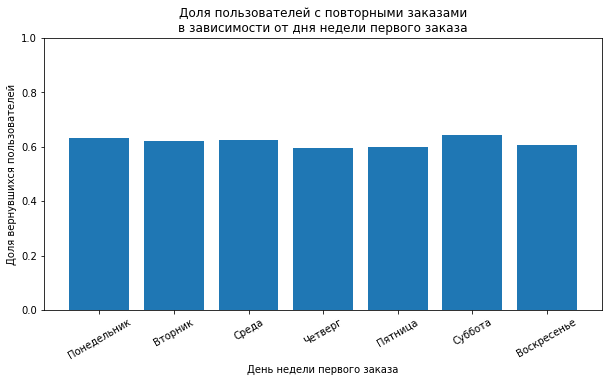

In [84]:
plt.figure(figsize=(10, 5))
plt.bar(
    weekday_returns['first_order_weekday_name'],
    weekday_returns['return_rate']
)

plt.title('Доля пользователей с повторными заказами\nв зависимости от дня недели первого заказа')
plt.xlabel('День недели первого заказа')
plt.ylabel('Доля вернувшихся пользователей')
plt.xticks(rotation=30)
plt.ylim(0, 1)

plt.show()

**Влияние дня недели первой покупки**

Пользователи распределены по дням недели первого заказа **достаточно равномерно**: в каждый день первую покупку совершили примерно 2.8–3.5 тыс. пользователей, что позволяет корректно сравнивать долю возвратов между сегментами без искажений из-за малого объёма данных.

Доля пользователей, совершивших повторные заказы, находится в диапазоне ~59–64% и слабо зависит от дня недели первой покупки:

- Понедельник–среда — стабильная доля возвратов на уровне 62–63%

- Четверг и пятница — немного более низкие значения (~59–60%)

- Суббота — наивысшая доля повторных заказов (~64%)

- Воскресенье — около 60%

Несмотря на небольшое преимущество выходных дней, различия между днями недели невелики. Ни один из дней не выделяется с существенно более высокой вероятностью возврата.

Вывод: день недели первой покупки оказывает слабое влияние на вероятность повторного заказа. Поведение пользователей после первой покупки остаётся схожим вне зависимости от того, в какой день недели был сделан первый заказ.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [86]:
# Пользователи с 2–4 заказами
group_2_4 = user_profile[
    (user_profile['orders_count'] >= 2) &
    (user_profile['orders_count'] <= 4)
]

# Пользователи с 5 и более заказами
group_5_plus = user_profile[
    user_profile['orders_count'] >= 5
]

In [87]:
group_2_4['avg_days_between'].describe()

count    7147.000000
mean       21.329940
std        28.484605
min         0.000000
25%         0.000000
50%         9.000000
75%        34.000000
max       148.000000
Name: avg_days_between, dtype: float64

In [88]:
group_5_plus['avg_days_between'].describe()

count    6339.000000
mean        9.578355
std         7.860176
min         0.000000
25%         3.424038
50%         7.789474
75%        13.777778
max        37.500000
Name: avg_days_between, dtype: float64

**Влияние среднего интервала между заказами**

Средний интервал между покупками заметно различается у пользователей с разным числом заказов.

Для пользователей, совершивших 2–4 заказа, характерны более длинные промежутки между покупками:

- среднее значение — ~21 день;

- медиана — 9 дней;

- у 25% пользователей интервал равен 0 дней, что указывает на повторные покупки в один и тот же день;

- 75% пользователей совершают следующую покупку в течение 34 дней;

- наблюдаются редкие, но длинные интервалы до 148 дней, что увеличивает разброс значений.

Для пользователей, совершивших 5 и более заказов, покупки происходят значительно чаще:

- средний интервал — около 9.6 дня;

- медиана — 7.8 дня;

- 75% пользователей возвращаются в течение 14 дней;

- максимальный интервал существенно ниже — ~38 дней, распределение более компактное.

Таким образом, пользователи с большим числом заказов характеризуются более короткими и стабильными интервалами между покупками, тогда как у пользователей с 2–4 заказами поведение менее регулярное и с более длинными паузами между заказами.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [94]:
# Выбираем признаки профиля пользователя
profile_cols = [
    'orders_count',
    'first_event_type',
    'first_device',
    'first_region',
    'first_service',
    'avg_revenue_rub',
    'avg_tickets_count'
]

phik_corr = user_profile[profile_cols].phik_matrix(
    interval_cols=['orders_count', 'avg_revenue_rub', 'avg_tickets_count']
)

phik_corr

,orders_count,first_event_type,first_device,first_region,first_service,avg_revenue_rub,avg_tickets_count
orders_count,1.000000,0.000000,0.000000,0.127203,0.101909,0.000000,0.000000
first_event_type,0.000000,1.000000,0.061082,0.511205,0.587582,0.326968,0.095147
first_device,0.000000,0.061082,1.000000,0.115952,0.081924,0.075204,0.055322
first_region,0.127203,0.511205,0.115952,1.000000,0.696568,0.362065,0.164722
first_service,0.101909,0.587582,0.081924,0.696568,1.000000,0.377779,0.066905
avg_revenue_rub,0.000000,0.326968,0.075204,0.362065,0.377779,1.000000,0.461196
avg_tickets_count,0.000000,0.095147,0.055322,0.164722,0.066905,0.461196,1.000000


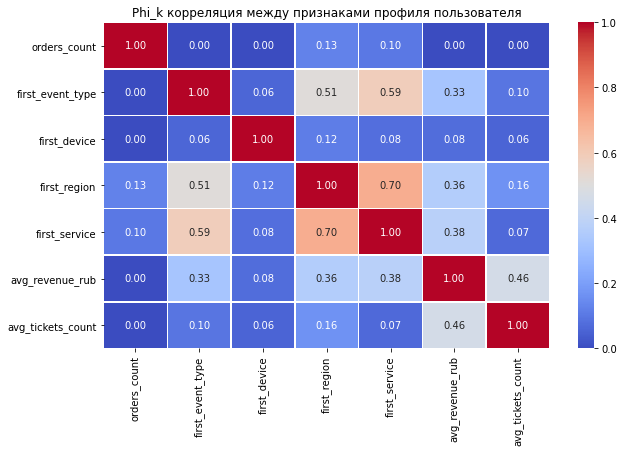

In [102]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    phik_corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Phi_k корреляция между признаками профиля пользователя')
plt.show()

In [97]:
user_profile['orders_count'].value_counts().head(10)

1     8368
2     3572
3     2175
4     1400
5      971
6      700
7      542
8      455
9      384
10     291
Name: orders_count, dtype: int64

In [99]:
#Создать сегменты по числу заказов
user_profile['orders_segment'] = pd.cut(
    user_profile['orders_count'],
    bins=[0, 1, 4, user_profile['orders_count'].max()],
    labels=['1 заказ', '2–4 заказа', '5+ заказов']
)

user_profile['orders_segment'].value_counts()


1 заказ       8368
2–4 заказа    7147
5+ заказов    6339
Name: orders_segment, dtype: int64

In [100]:
segment_cols = [
    'orders_segment',
    'first_event_type',
    'first_device',
    'first_region',
    'first_service',
    'avg_revenue_rub',
    'avg_tickets_count'
]

phik_corr_segmented = user_profile[segment_cols].phik_matrix(
    interval_cols=['avg_revenue_rub', 'avg_tickets_count']
)

phik_corr_segmented

,orders_segment,first_event_type,first_device,first_region,first_service,avg_revenue_rub,avg_tickets_count
orders_segment,1.000000,0.041205,0.016259,0.125589,0.085467,0.334764,0.390477
first_event_type,0.041205,1.000000,0.061082,0.511205,0.587582,0.326968,0.095147
first_device,0.016259,0.061082,1.000000,0.115952,0.081924,0.075204,0.055322
first_region,0.125589,0.511205,0.115952,1.000000,0.696568,0.362065,0.164722
first_service,0.085467,0.587582,0.081924,0.696568,1.000000,0.377779,0.066905
avg_revenue_rub,0.334764,0.326968,0.075204,0.362065,0.377779,1.000000,0.461196
avg_tickets_count,0.390477,0.095147,0.055322,0.164722,0.066905,0.461196,1.000000


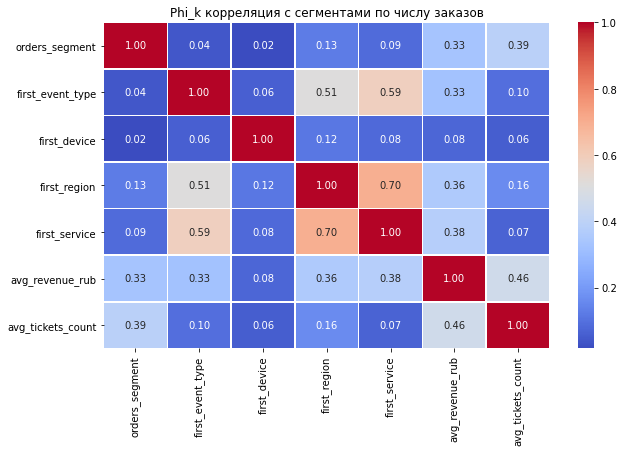

In [101]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    phik_corr_segmented,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Phi_k корреляция с сегментами по числу заказов')
plt.show()


**Корреляционный анализ (phi_k)**

Для оценки связей между признаками профиля пользователя и количеством заказов использован коэффициент phi_k. Интервальные признаки: `orders_count`, `avg_revenue_rub`, `avg_tickets_count`.

По матрице phik_corr видно, что связи `orders_count` с признаками первого заказа в целом слабые (значения близки к 0).

Пользователи были сегментированы по числу заказов (`orders_segment`: 1 заказ, 2–4 заказа, 5+ заказов) и корреляция рассчитана повторно (phik_corr_segmented).

В сегментированном варианте наиболее заметная связь с `orders_segment` наблюдается у:

`avg_tickets_count` (phi_k ≈ 0.39)

`avg_revenue_rub` (phi_k ≈ 0.33)

Категориальные признаки первого заказа (тип события, регион, оператор, устройство) остаются слабо связаны с количеством заказов.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

### 5. Общий вывод и рекомендации

#### Кратко о данных и подготовке

В работе использовались данные о заказах пользователей **Яндекс Афиши**, на основе которых был построен **профиль пользователя**.

В ходе предобработки данных:
- проверены и обработаны пропуски;
- приведены типы данных (даты, числовые поля);
- удалены выбросы по выручке (фильтрация по **99-му перцентилю**);
- рассчитаны агрегированные признаки: **число заказов**, **средняя выручка**, **среднее число билетов**, **интервалы между покупками**;
- пользователи сегментированы по числу заказов и поведенческим характеристикам.

В итоговой выборке — **21 854 пользователя**.

---

#### Основные результаты анализа

**Распределение пользователей по заказам** неравномерное:  
большинство совершают **1–2 заказа**, однако значимая доля пользователей делает **5 и более заказов**.

**Признаки первого заказа:**
- наиболее массовые «точки входа» — **концерты** и **мобильные устройства**;
- различия в возврате по типу мероприятия и устройству **незначительные**;
- гипотеза о том, что **спортивные мероприятия дают больший возврат**, **не подтвердилась**.

**Выручка и билеты:**
- средняя выручка с заказа почти не различается между разовыми и возвращающимися пользователями;
- наибольшая доля повторных заказов наблюдается у пользователей, покупающих в среднем **2–3 билета**;
- сегменты **1–2 билета** и **5+ билетов** демонстрируют более низкое удержание.

**Временные характеристики:**
- день недели первого заказа **слабо влияет** на вероятность возврата;
- пользователи с **5+ заказами** имеют значительно **меньший средний интервал между покупками**, чем пользователи с 2–4 заказами.

**Корреляционный анализ (phi_k)** показал:
- слабую связь числа заказов с признаками первого заказа;
- наиболее заметную связь числа заказов с:
  - **avg_tickets_count** (phi_k ≈ **0.39**);
  - **avg_revenue_rub** (phi_k ≈ **0.33**).

---

#### Рекомендации заказчику

- Сфокусироваться на пользователях, покупающих **2–3 билета** — это самый массовый и наиболее «возвращаемый» сегмент.
- Использовать **частоту покупок** и **интервалы между заказами** как ключевые сигналы удержания (триггерные рассылки, напоминания).
- Не делать ставку только на тип первого мероприятия — его влияние на возврат ограничено.
- Усилить работу с пользователями сегмента **1–2 билета** — это потенциальная зона роста повторных покупок.
- Для моделей прогнозирования возврата опираться прежде всего на **поведенческие признаки**, а не только на характеристики первого заказа.


### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**